# Zoom surveillance

## [Download worked project](../../_static/generated/zoom-surveillance-prj.zip) 

[Browse files online](https://github.com/DavidLeoni/softpython-en/tree/master/projects/zoom-surveillance)

A training center holds online courses with [Zoom software](https://zoom.us/). Participants attendance is mandatory, and teachers want to determine who left, when and for what reason. Zoom allows to save a meeting log in a sort of CSV format which holds the timings of joins and leaves of each student. You will clean the file content and show relevant data in charts. 

If you're a student, you are basically going to build a surveillance system to monitor YOU. Welcome to digital age.


## What to do

1. Unzip exercises zip in a folder, you should obtain something like this:

```
zoom-prj
    zoom.ipynb
    zoom-sol.ipynb
    UserQos_12345678901.csv
    jupman.py
```

<div class="alert alert-warning">

**WARNING: to correctly visualize the notebook, it MUST be in an unzipped folder !**
</div>

2. open Jupyter Notebook from that folder. Two things should open, first a console and then a browser. The browser should show a file list: navigate the list and open the notebook `zoom.ipynb`

3. Go on reading the notebook, and write in the appropriate cells when asked

Shortcut keys:

- to execute Python code inside a Jupyter cell, press `Control + Enter`

- to execute Python code inside a Jupyter cell AND select next cell, press `Shift + Enter`

- to execute Python code inside a Jupyter cell AND a create a new cell aftwerwards, press `Alt + Enter`

- If the notebooks look stuck, try to select `Kernel -> Restart`


## CSV format

You are provided with the file  [UserQos_12345678901.csv](UserQos_12345678901.csv). Unfortunately, it is a weird CSV which actually looks like two completely different CSVs were merged together, one after the other. It contains the following:

* 1st line: general meeting header
* 2nd line: general meeting data
* 3rd line: empty
* 4th line completely different header for participant sessions for that meeting. Each session contains a join time and a leave time, and each participant can have multiple sessions in a meeting.
* 5th line and following: sessions data

The file has lots of useless fields, try to explore it and understand the format (use LibreOffice Calc to help yourself)

Here we only show the few fields we are actually interested in, and examples of trasformations you should apply:

From general meeting information section:

- `Meeting ID`: `123 4567 8901`
- `Topic`: `Hydraulics Exam`
- `Start Time`: `"Apr 17, 2020 02:00 PM"` should become  `Apr 17, 2020` 

From participant sessions section:

- `Participant`: `Luigi` 
- `Join Time`: `01:54 PM` should become `13:54` 
- `Leave Time`: `03:10 PM(Luigi got disconnected from the meeting.Reason: Network connection error. )` should be split into two fields, one for actual leave time in `15:10` format and another one for disconnection reason.

There are 3 possible disconnection reasons (try to come up with a general way to parse them - **notice that there is no dot at the end of transformed string**):

- `(Luigi got disconnected from the meeting.Reason: Network connection error. )` should become `Network connection error`
- `(Bowser left the meeting.Reason: Host closed the meeting. )` should become `Host closed the meeting`
- `(Princess Toadstool left the meeting.Reason: left the meeting.)` should become `left the meeting`

Your first goal will be to load the dataset and restructure the data so it looks like this:

```python
[['meeting_id', 'topic', 'date', 'participant', 'join_time', 'leave_time', 'reason'],
 ['123 4567 8901','Hydraulics Exam','Apr 17, 2020','Luigi','13:54','15:10','Network connection error'],
 ['123 4567 8901','Hydraulics Exam','Apr 17, 2020','Luigi','15:12','15:54','left the meeting'],
 ['123 4567 8901','Hydraulics Exam','Apr 17, 2020','Mario','14:02','14:16','Network connection error'],
 ['123 4567 8901','Hydraulics Exam','Apr 17, 2020','Mario','14:19','15:02','Network connection error'],
 ['123 4567 8901','Hydraulics Exam','Apr 17, 2020','Mario','15:04','15:50','Network connection error'],
 ['123 4567 8901','Hydraulics Exam','Apr 17, 2020','Mario','15:52','15:55','Network connection error'],
 ['123 4567 8901','Hydraulics Exam','Apr 17, 2020','Mario','15:56','16:00','Host closed the meeting'],
 ...
]
```

## 1. time24

To fix the times, you will first need to implement the following function.

In [1]:
def time24(t):
    """ Takes a time string like '06:27 PM' and outputs a string like 18:27
    """
    
    if t.endswith('AM'):
        if t.startswith('12:00'):
            return '00:00'
        else:
            return t.replace(' AM', '')
    else:
        if t.startswith('12:00'):
            return '12:00'
            
        h = '%0.d' % (int(t.split(':')[0]) + 12)
        
        return h + ':' + t.split(':')[1].replace(' PM','')
    
    
assert time24('12:00 AM') == '00:00'  # midnight
assert time24('01:06 AM') == '01:06' 
assert time24('09:45 AM') == '09:45'
assert time24('12:00 PM') == '12:00'  # special case, it's actually midday
assert time24('01:27 PM') == '13:27'
assert time24('06:27 PM') == '18:27'
assert time24('10:03 PM') == '22:03'

In [1]:
def time24(t):
    """ Takes a time string like '06:27 PM' and outputs a string like 18:27
    """
    raise Exception('TODO IMPLEMENT ME !')
    
assert time24('12:00 AM') == '00:00'  # midnight
assert time24('01:06 AM') == '01:06' 
assert time24('09:45 AM') == '09:45'
assert time24('12:00 PM') == '12:00'  # special case, it's actually midday
assert time24('01:27 PM') == '13:27'
assert time24('06:27 PM') == '18:27'
assert time24('10:03 PM') == '22:03'

## 2. load

Implement a function which loads the file [UserQos_12345678901.csv](UserQos_12345678901.csv) and RETURN a list of lists, see the format in `EXPECTED_MEETING_LOG` provided below.

To parse the file, you can use simple [CSV reader](https://en.softpython.org/formats/formats2-csv-sol.html)  (there is no need to use pandas)

In [2]:

import csv

def load(filepath): 
    
    ret = []
    with open(filepath, encoding='utf-8', newline='') as f:

        my_reader = csv.reader(f, delimiter=',')
        next(my_reader)
        row_meeting = next(my_reader)
        meeting_id = row_meeting[0]            
        topic = row_meeting[1]
        meeting_date = row_meeting[7]        
        next(my_reader) # empty row
        next(my_reader) # second header        
        ret.append(['meeting_id', 'topic','date', 'participant','join_time','leave_time','reason'])
        for row in my_reader:            
            session = {}
            if len(row) > 0:
                ret.append([meeting_id,
                            topic,
                            meeting_date[:12],
                            row[0],                            
                            time24(row[10]), 
                            time24(row[11].split('(')[0]),
                            row[11].split('Reason: ')[1].split('.')[0]])
    return ret
           

meeting_log = load('UserQos_12345678901.csv')

from pprint import pprint
pprint(meeting_log, width=150)

[['meeting_id', 'topic', 'date', 'participant', 'join_time', 'leave_time', 'reason'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Luigi', '13:54', '15:10', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Luigi', '15:12', '15:54', 'left the meeting'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Mario', '14:02', '14:16', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Mario', '14:19', '15:02', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Mario', '15:04', '15:50', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Mario', '15:52', '15:55', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Mario', '15:56', '16:00', 'Host closed the meeting'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Bowser', '14:15', '14:30', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr

In [2]:

import csv

def load(filepath): 
    raise Exception('TODO IMPLEMENT ME !')       

meeting_log = load('UserQos_12345678901.csv')

from pprint import pprint
pprint(meeting_log, width=150)

In [3]:
EXPECTED_MEETING_LOG = \
[['meeting_id', 'topic', 'date', 'participant', 'join_time', 'leave_time', 'reason'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Luigi', '13:54', '15:10', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Luigi', '15:12', '15:54', 'left the meeting'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Mario', '14:02', '14:16', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Mario', '14:19', '15:02', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Mario', '15:04', '15:50', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Mario', '15:52', '15:55', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Mario', '15:56', '16:00', 'Host closed the meeting'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Bowser', '14:15', '14:30', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Bowser', '14:54', '15:03', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Bowser', '15:12', '15:40', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Bowser', '15:45', '16:00', 'Host closed the meeting'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Princess Toadstool', '13:56', '15:33', 'left the meeting'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Wario', '14:05', '14:10', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Wario', '14:15', '14:29', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Wario', '14:33', '15:10', 'left the meeting'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Wario', '15:25', '15:54', 'Network connection error'],
 ['123 4567 8901', 'Hydraulics Exam', 'Apr 17, 2020', 'Wario', '15:55', '16:00', 'Host closed the meeting']]

assert meeting_log[0]   == EXPECTED_MEETING_LOG[0]    # header
assert meeting_log[1]   == EXPECTED_MEETING_LOG[1]    # first Luigi row
assert meeting_log[1:3] == EXPECTED_MEETING_LOG[1:3]  # Luigi rows
assert meeting_log[:4]  == EXPECTED_MEETING_LOG[:4]   # until first Mario row included
assert meeting_log      == EXPECTED_MEETING_LOG       # all table

## 3.1 duration

Given two times as strings `a` and `b` in format like `17:34`, RETURN the duration in minutes between them as an integer. 

To calculate gap durations, **we assume a meeting NEVER ends after midnight**

In [4]:
def duration(a, b):
    
    asp = a.split(':')    
    ta = int(asp[0])*60+int(asp[1]) 
    bsp = b.split(':')
    tb = int(bsp[0])*60 + int(bsp[1])
    return tb - ta
    
    
assert duration('15:00','15:34') == 34
assert duration('15:00','17:34') == 120 + 34
assert duration('15:50','16:12') == 22
assert duration('09:55','11:06') == 5 + 60 + 6
assert duration('00:00','00:01') == 1
#assert duration('11:58','00:01') == 3  # no need to support this case !!

In [4]:
def duration(a, b):
    raise Exception('TODO IMPLEMENT ME !')
    
assert duration('15:00','15:34') == 34
assert duration('15:00','17:34') == 120 + 34
assert duration('15:50','16:12') == 22
assert duration('09:55','11:06') == 5 + 60 + 6
assert duration('00:00','00:01') == 1
#assert duration('11:58','00:01') == 3  # no need to support this case !!

## 3.2 calc_stats

We want to know something about the time each participant has been disconnected from the exam. We call such intervals `gaps`, which are the difference between a session leave time and **successive** session join time.

Implement the function `calc_stats` that given a cleaned log produced by `load`, RETURN a dictionary mapping each partecipant to a dictionary with these statistics:

- `max_gap` : the longest time in minutes in which the participant has been disconnected
- `gaps` : the number of disconnections happend to the participant during the meeting
- `time_away` : the total time in minutes during which the participant has been disconnected during the meeting

To calculate gap durations, **we assume a meeting NEVER ends after midnight**

For the data format details, see `EXPECTED_STATS` below.

<div class="alert alert-warning">

**To test the function, you DON'T NEED to have correctly implemented previous functions** 

</div>


In [5]:


def calc_stats(log):
    
    ret = {}
    
    last_sessions = {}
    
    first = True
    for session in log:
        if first:
            first = False
            continue
        date = session[2]
        participant = session[3]
        join_time = session[4]
        leave_time = session[5]
        reason = session[6]
        
        if participant not in ret:
            ret[participant] = {'max_gap': 0,
                                'gaps': 0,
                                'time_away':0
                               }                                        
        
        if participant in last_sessions:
            last_leave_time = last_sessions[participant][5]                        
            gap = duration(last_leave_time, join_time)            
            ret[participant]['max_gap'] = max(gap, ret[participant]['max_gap'])
            ret[participant]['gaps'] += 1
            ret[participant]['time_away'] += gap
        
        last_sessions[participant] = session
    return ret
    
    

stats = calc_stats(meeting_log)

# in case you had trouble implementing load function, use this: 
#stats = calc_stats(EXPECTED_MEETING_LOG)

stats

{'Luigi': {'max_gap': 2, 'gaps': 1, 'time_away': 2},
 'Mario': {'max_gap': 3, 'gaps': 4, 'time_away': 8},
 'Bowser': {'max_gap': 24, 'gaps': 3, 'time_away': 38},
 'Princess Toadstool': {'max_gap': 0, 'gaps': 0, 'time_away': 0},
 'Wario': {'max_gap': 15, 'gaps': 4, 'time_away': 25}}

In [5]:


def calc_stats(log):
    raise Exception('TODO IMPLEMENT ME !')
    

stats = calc_stats(meeting_log)

# in case you had trouble implementing load function, use this: 
#stats = calc_stats(EXPECTED_MEETING_LOG)

stats

In [6]:
EXPECTED_STATS = {'Bowser': {'gaps': 3, 'max_gap': 24, 'time_away': 38},
                   'Luigi': {'gaps': 1, 'max_gap': 2,  'time_away': 2},
                   'Mario': {'gaps': 4, 'max_gap': 3,  'time_away': 8},
      'Princess Toadstool': {'gaps': 0, 'max_gap': 0,  'time_away': 0},
                   'Wario': {'gaps': 4, 'max_gap': 15, 'time_away': 25}}

assert stats == EXPECTED_STATS

## 4. viz

Produce a bar chart of the statistics you calculated before. For how to do it, see example [here](https://en.softpython.org/visualization/visualization1-sol.html#Exercise---superheroes)

- participant names MUST be sorted in alphabetical order
- remember to put title, legend and axis labels

<div class="alert alert-warning">

**To test the function, you DON'T NEED to have correctly implemented previous functions** 

</div>

![expected-plot](expected-plot.png)

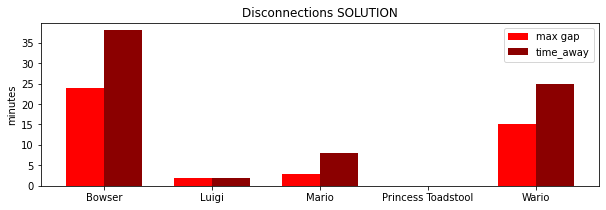

In [7]:

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def viz(stats):
    
    
    xs = np.arange(len(stats))
    ys_max_gap = []
    ys_time_away = []
    
    labels = list(sorted(stats.keys()))
    
    for participant in sorted(stats):
        pstats = stats[participant]
        ys_max_gap.append(pstats['max_gap'])
        ys_time_away.append(pstats['time_away'])
        
    width = 0.35
    fig, ax = plt.subplots(figsize=(10,3))
    rects1 = ax.bar(xs - width/2, ys_max_gap, width, 
                    color='red', label='max gap')
    rects2 = ax.bar(xs + width/2, ys_time_away, width,
                    color='darkred', label='time_away')

    plt.xticks(xs, labels)
        
    ax.set_title('Disconnections SOLUTION')
    ax.legend()
        
    plt.ylabel('minutes')    
    
    plt.show()
    
        
viz(stats)

# in case you had trouble implementing calc_stats, use this:
#viz(EXPECTED_STATS)

In [7]:

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def viz(stats):
    raise Exception('TODO IMPLEMENT ME !')
        
viz(stats)

# in case you had trouble implementing calc_stats, use this:
#viz(EXPECTED_STATS)